# SPEI at Socorro USHCN site

In [5]:
# Data are from the Socorro USHCN site (298387)
# UHCN data browser is at http://cdiac.ornl.gov/epubs/ndp/ushcn/ushcn_map_interface.html
# data link: http://cdiac.ornl.gov/cgi-bin/broker?_PROGRAM=prog.climsite_monthly.sas&_SERVICE=default&id=298387&_DEBUG=0
fname <- 'spei_input_files/NM298387_3539.csv'
lat <- 34.0828 # Latitude of the station

# Get spei tools
source('~/current/GitHub/climate_tools/spei.r')

df <- read.csv(fname, skip=1, header=TRUE)
head(df)

State_id,YEAR,Month,CPRECIP..in.,PRECIP..in.,PRECIP_f,TMAX..F.,TMAX_f,TMEAN..F.,TMEAN_f,TMIN..F.,TMIN_f
'298387',1900,1,1.35,1.35,' ',45.8,' ',32.7,' ',19.7,' '
'298387',1900,2,1.85,0.50,' ',49.6,' ',35.0,' ',20.5,' '
'298387',1900,3,2.51,0.66,' ',59.3,' ',44.2,' ',29.1,' '
'298387',1900,4,2.69,0.18,' ',60.9,' ',45.9,' ',31.0,' '
'298387',1900,5,3.15,0.46,' ',77.7,' ',61.2,' ',44.8,' '
'298387',1900,6,3.34,0.19,' ',88.6,' ',72.3,' ',56.0,' '


In [6]:
# Convert units
prec_mm <- df$PRECIP..in. * 25.400
tmean_c <- (df$TMEAN..F. - 32) * (5/9)

# Get pet with thornthwaite - since we're missing wind I don't think penman is an option
pet <- thornthwaite(tmean_c, lat)

In [7]:
# Convert to xts
# Get dates
dateidx <- as.yearmon(paste(df$Month, '/', df$YEAR, sep=''), "%m/%Y")

prec_mm_xts <- xts(prec_mm, order.by=dateidx)
pet_xts <- xts(as.numeric(pet), order.by=dateidx)

head(prec_mm_xts)
head(pet_xts)

           [,1]
Jan 1900 34.290
Feb 1900 12.700
Mar 1900 16.764
Apr 1900  4.572
May 1900 11.684
Jun 1900  4.826

                [,1]
Jan 1900   0.3885503
Feb 1900   2.6849815
Mar 1900  21.6510779
Apr 1900  27.3064617
May 1900  82.2138047
Jun 1900 126.7129518

In [8]:
# Calculate climatic water difference
cwdiff <- get_cwdiff(prec_mm_xts, pet_xts)
head(cwdiff)

                [,1]
Jan 1900   33.901450
Feb 1900   10.015018
Mar 1900   -4.887078
Apr 1900  -22.734462
May 1900  -70.529805
Jun 1900 -121.886952

## 6 month SPEI

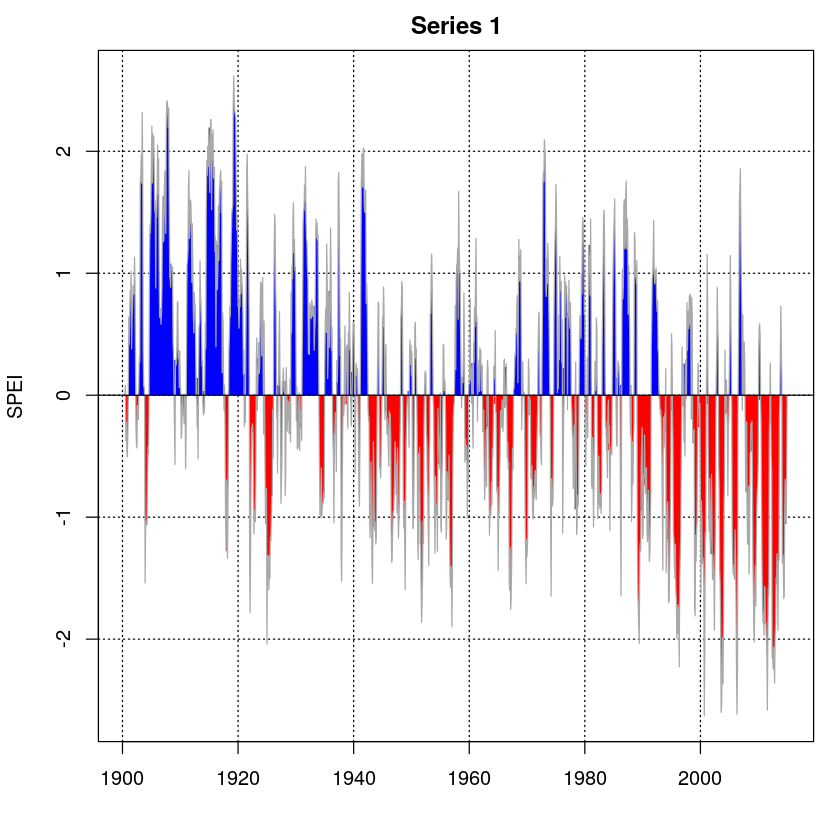

In [9]:
# Calculating spei using the R package described here: http://sac.csic.es/spei/tools.html
# By default this will fetch 6 month integrated SPEI
spei_6mo <- get_spei(cwdiff)

In [10]:
# Extract SPEI values into an xts object
spei_xts <- cwdiff
colnames(spei_xts) <- c('cwdiff')
spei_xts$spei6mo <- xts(as.vector(spei_6mo$fitted),  order.by=index(cwdiff))

head(spei_xts)

              cwdiff   spei6mo
Jan 1900   33.901450        NA
Feb 1900   10.015018        NA
Mar 1900   -4.887078        NA
Apr 1900  -22.734462        NA
May 1900  -70.529805        NA
Jun 1900 -121.886952 0.9030355

## 12 Month SPEI

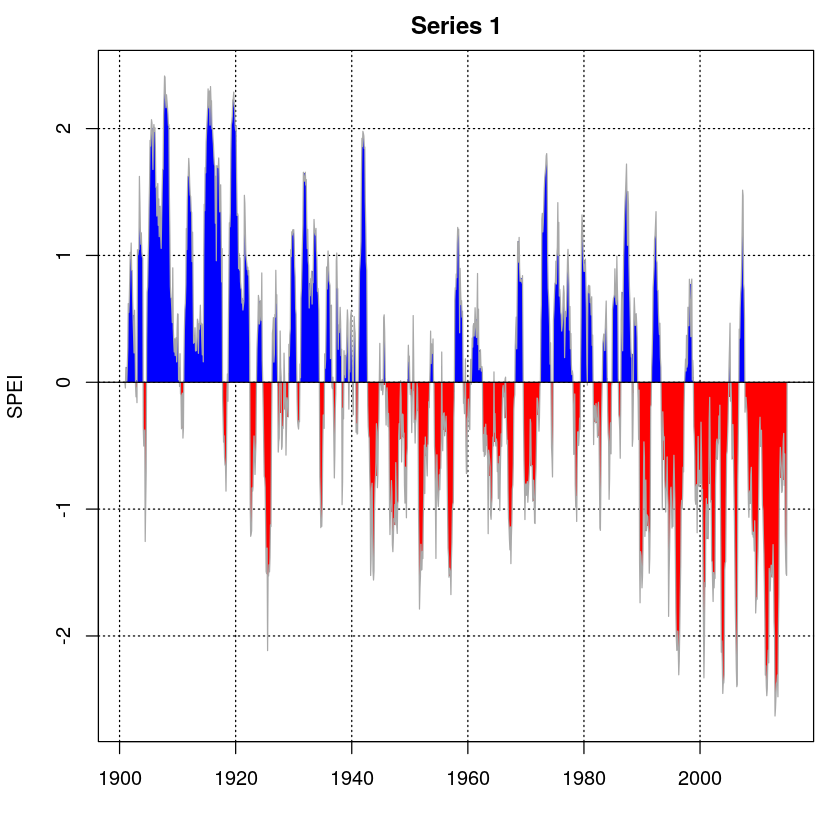

In [11]:
# Now get 1year
spei_12mo <- get_spei(cwdiff, int_per=12)

In [12]:
# Add to xts
spei_xts$spei12mo <- xts(as.vector(spei_12mo$fitted),  order.by=index(cwdiff))
head(spei_xts)

              cwdiff   spei6mo spei12mo
Jan 1900   33.901450        NA       NA
Feb 1900   10.015018        NA       NA
Mar 1900   -4.887078        NA       NA
Apr 1900  -22.734462        NA       NA
May 1900  -70.529805        NA       NA
Jun 1900 -121.886952 0.9030355       NA

## Is there a significant trend?

In [13]:
library(forecast)


Call:
tslm(formula = spei_ts ~ trend)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.45251 -0.67122 -0.01229  0.64362  2.46660 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.196e-01  4.880e-02   14.75   <2e-16 ***
trend       -1.040e-03  6.143e-05  -16.92   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9042 on 1373 degrees of freedom
Multiple R-squared:  0.1726,	Adjusted R-squared:  0.172 
F-statistic: 286.3 on 1 and 1373 DF,  p-value: < 2.2e-16



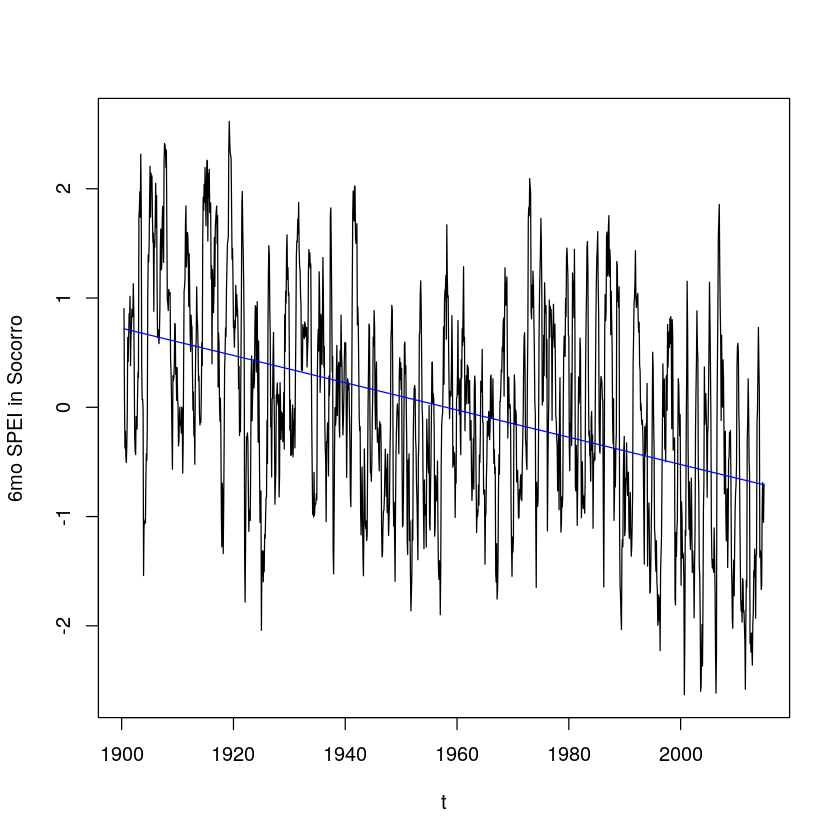

In [14]:
spei_ts <- ts(spei_xts$spei6mo[6:length(spei_xts$spei6mo)], frequency=12, start=c(1900, 6))
spei.fit <- tslm(spei_ts ~ trend)
plot(spei_ts, ylab="6mo SPEI in Socorro", xlab="t")
lines(fitted(spei.fit), col='blue')
print(summary(spei.fit))
# Looks like it

## Coefficient of Variation

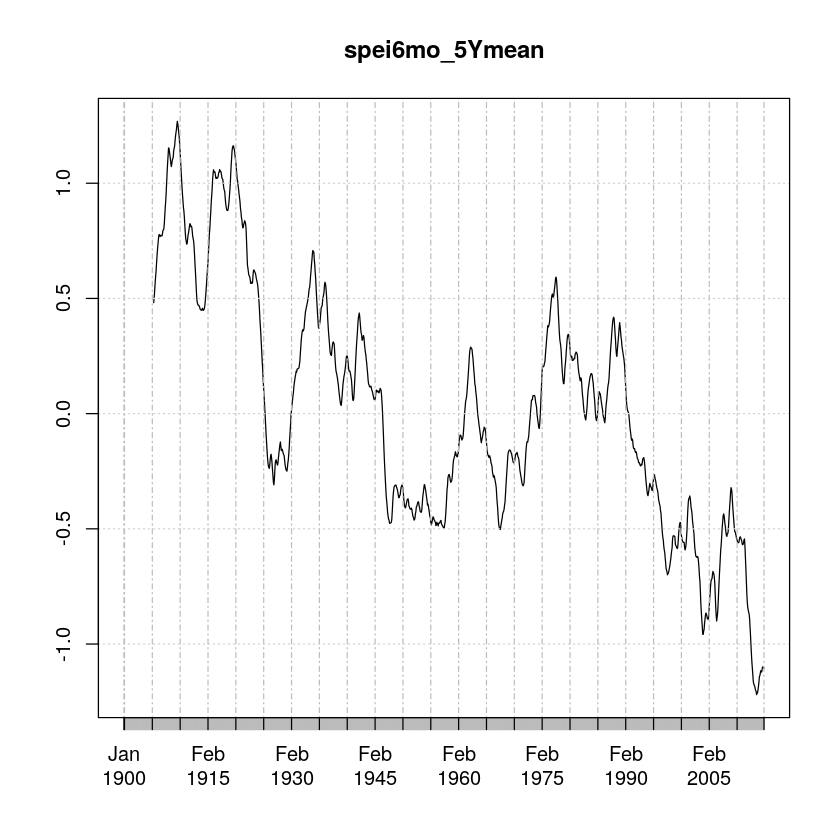

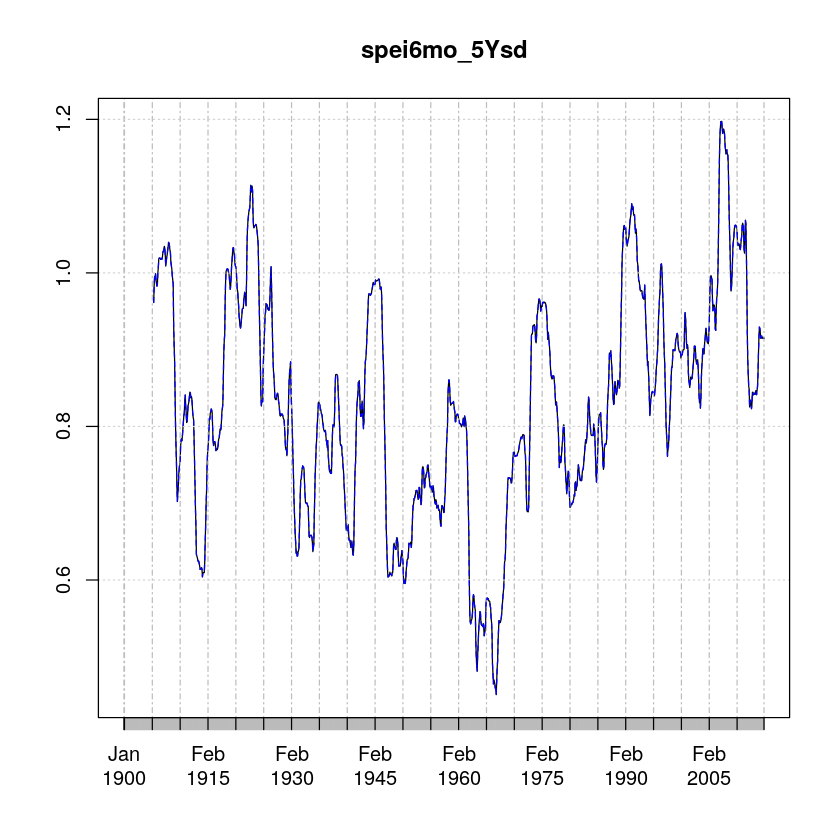

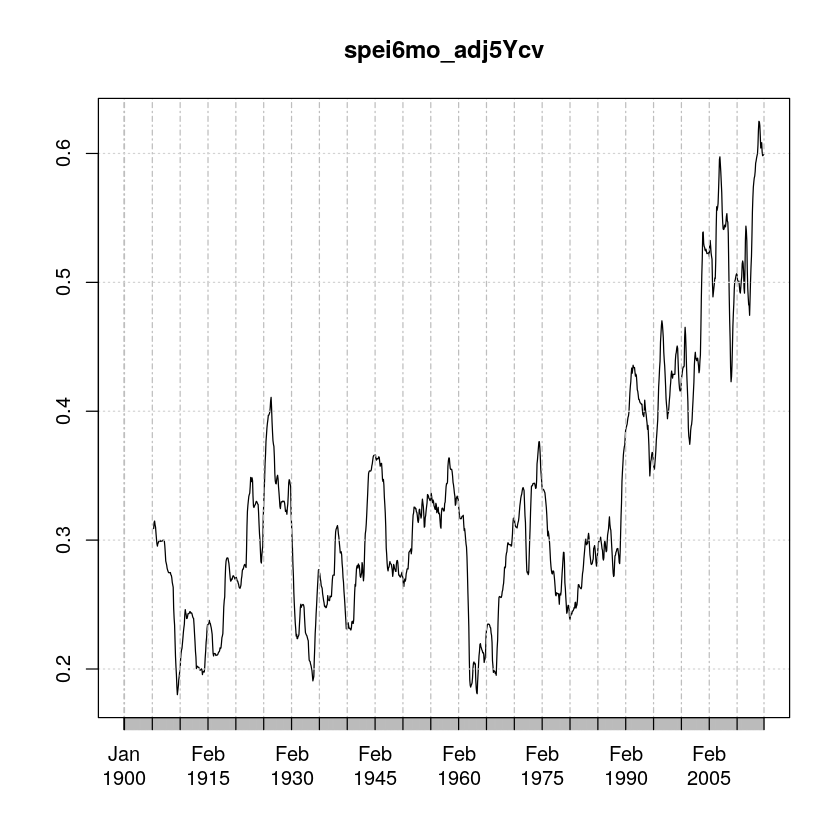


Call:
tslm(formula = cv_ts ~ trend)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.151231 -0.038422 -0.000428  0.041820  0.189765 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.135e-01  3.767e-03   56.68   <2e-16 ***
trend       1.699e-04  4.954e-06   34.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06828 on 1314 degrees of freedom
Multiple R-squared:  0.4722,	Adjusted R-squared:  0.4718 
F-statistic:  1175 on 1 and 1314 DF,  p-value: < 2.2e-16



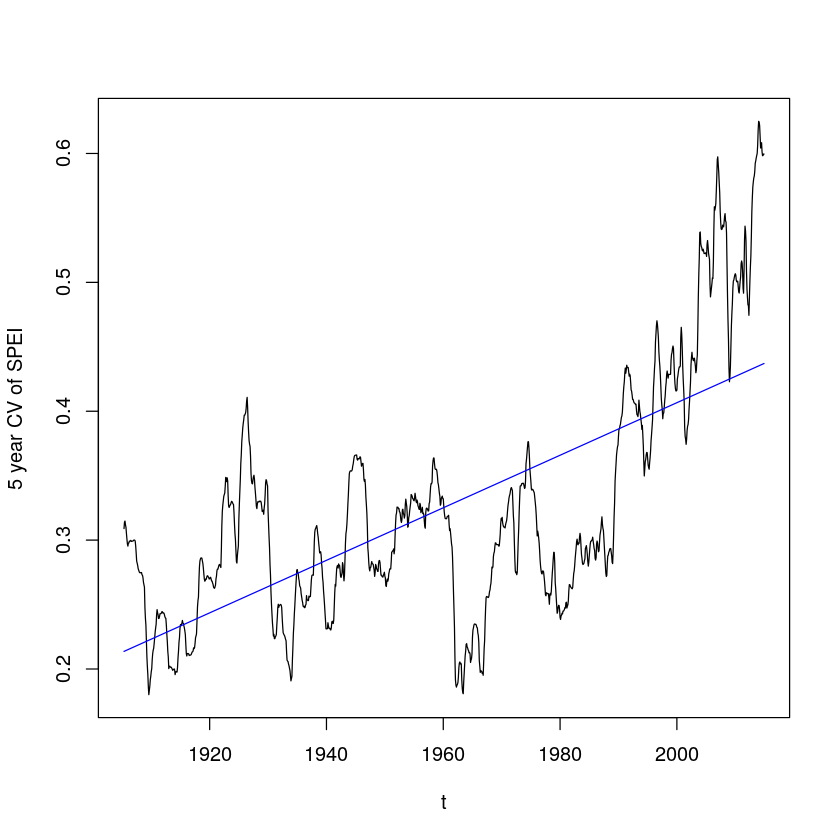

In [15]:
# 5 year rolling CV calculation
# Specify window width
wid <- 5*12
# Calculate 5 year mean SPEI
spei6mo_5Ymean <- rollapply(spei_xts$spei6mo, wid, mean, align='right')
# Calculate an adjusted spei (>0 for calculating CV) then get its 5Y mean
spei6mo_adj <- spei_xts$spei6mo - min(spei_xts$spei6mo, na.rm=TRUE)
spei6mo_adj5Ymean <- rollapply(spei6mo_adj, wid, mean, align='right')

# Standard dev
spei6mo_5Ysd <- rollapply(spei_xts$spei6mo, wid, sd, align='right')
# Standard deviation of adjusted data
spei6mo_adj5Ysd <- rollapply(spei6mo_adj, wid, sd, align='right')
# CV
spei6mo_adj5Ycv <- spei6mo_adj5Ysd/spei6mo_adj5Ymean

# Plot mean
plot(spei6mo_5Ymean)
# Plot sd and adjusted-data sd (they should be the same)
plot(spei6mo_5Ysd)
lines(spei6mo_adj5Ysd, col='blue', lty=2)
# Plot cv
plot(spei6mo_adj5Ycv)

# Look for a trend in CV and plot again
cv_ts <- ts(spei6mo_adj5Ycv[(wid+5):length(spei6mo_adj5Ycv)], frequency=12, start=c(1905, 5))
cv.fit <- tslm(cv_ts ~ trend)
plot(cv_ts, ylab="5 year CV of SPEI", xlab="t")
lines(fitted(cv.fit), col='blue')
print(summary(cv.fit))

# Add to xts
spei_xts$spei6mo_5Ymean <- spei6mo_5Ymean
spei_xts$spei6mo_adj5Ymean <- spei6mo_adj5Ymean
spei_xts$spei6mo_5Ysd <- spei6mo_5Ysd
spei_xts$spei6mo_adj5Ysd <- spei6mo_adj5Ysd
spei_xts$spei6mo_adj5Ycv <- spei6mo_adj5Ycv

In [16]:
head(spei_xts)
# Write data
outfile <- 'socorro_1900_spei'
write.zoo(spei_xts, file = paste('output_data/Sev_SPEI/', outfile, '.csv', sep=''),
          index.name = "Date", sep=',', row.names = FALSE, col.names=TRUE)

              cwdiff   spei6mo spei12mo spei6mo_5Ymean spei6mo_adj5Ymean
Jan 1900   33.901450        NA       NA             NA                NA
Feb 1900   10.015018        NA       NA             NA                NA
Mar 1900   -4.887078        NA       NA             NA                NA
Apr 1900  -22.734462        NA       NA             NA                NA
May 1900  -70.529805        NA       NA             NA                NA
Jun 1900 -121.886952 0.9030355       NA             NA                NA
         spei6mo_5Ysd spei6mo_adj5Ysd spei6mo_adj5Ycv
Jan 1900           NA              NA              NA
Feb 1900           NA              NA              NA
Mar 1900           NA              NA              NA
Apr 1900           NA              NA              NA
May 1900           NA              NA              NA
Jun 1900           NA              NA              NA